## important notes
- currently, using solar radiation intensity at 1 a.u. constant
    - while this is correct, we should rederive in our paper how this is calculated
- we should pick a single material to use as our dome

uncomment and run this cells if you get errors 

In [ ]:
# pip install scipy.optimize
# pip install matplotlib 
# pip install numpy

In [ ]:
import numpy as np 
import matplotlib.pyplot as plot 
from scipy.optimize import fsolve

### thermals stuff

In [ ]:
### important constants
# used for stefan-boltzman calculations
SIGMA = 5.67e-8 # W / m^2 / k
EPSILON = 1.0 # we are modeling as a "worst case" blackbody material
SOLAR_INTENSITY = 1320 # W / m^2
AIR_DENSITY = 1.225 # kg / m^3 
CP_AIR = 1004 # J / kg / k
T_INF = 3 # K 

In [ ]:
def point_source_heating(absorptivity, area, intensity):
    return absorptivity * area * intensity

def radiative_cooling(absorptivity, area, surface_temperature):
    return EPSILON * SIGMA * absorptivity * surface_temperature ** 4

def celsius_to_kelvin(temp):
    return temp + 273.15

class ThermalData:
    def __init__(self, radius, thickness, conductivity):
        self.radius = radius
        self.thickness = thickness
        self.conductivity = conductivity
        self.times = []
        self.internal_temperatures = []
        self.surface_temperatures = []
        self.q_dots = []

### general sphere stuff

In [ ]:
class Wall:
    def __init__(self, thickness, conductivity):
        self.thickness = thickness
        self.conductivity = conductivity

class Sphere:
    def __init__(self, radius, absorptivity, wall):
        self.radius = radius
        self.absorptivity = absorptivity
        self.wall = wall
        self.internal_temperature = celsius_to_kelvin(22) # placeholder for now
        self.surface_temperature = 5 # arbitrary starting value close to the temperature of space 
        self.reup_surface_temperature()
        self.light_intensity = SOLAR_INTENSITY

    def volume(self):
        return 4 / 3 * np.pi * self.radius**3

    def surface_area(self):
        return 4 * np.pi * self.radius**2

    def projected_area(self):
        return np.pi * self.radius * self.radius

    def mass(self):
        return self.volume() * AIR_DENSITY
    
    def reup_surface_temperature(self):
        def energy_balance(surface_temperature):
            q_cond = (self.wall.conductivity / self.wall.thickness) * (self.internal_temperature - surface_temperature) * self.surface_area()
            q_rad = radiative_cooling(EPSILON, self.surface_area(), surface_temperature)
            return q_cond - q_rad

        temperature_guess = (self.internal_temperature + T_INF) / 2 # start by guessing the average temperature
        solution = fsolve(energy_balance, temperature_guess) # use fsolve to find what temperature actually works
        self.surface_temperature = solution[0]

    def reup_internal_temperature(self, delta_time):
        q_net = self.total_heat_transfer()
        m = self.mass()
        delta_temp = (q_net * delta_time) / (m * CP_AIR) # this is obv just using 1st order integration, we can change this to RK4 later
        self.internal_temperature += delta_temp
        self.reup_surface_temperature()
   
    def total_heat_transfer(self):
        heating = point_source_heating(self.absorptivity, self.projected_area(), self.light_intensity)
        cooling = -radiative_cooling(self.absorptivity, self.surface_area(), self.surface_temperature)
        return heating + cooling


### this is acting as just a 'hello world' cell, make sure this runs with no errors

In [ ]:
# hello world 
sphere = Sphere(1, EPSILON, Wall(1, 1))
assert sphere.surface_area() == 4 * np.pi, "make sure this runs"
print("sphere area:", sphere.surface_area())
print("calculated surface temperature:", sphere.surface_temperature)

sphere area: 12.566370614359172
calculated surface temperature: 270.86307988561066


### first actual calculations for a dome

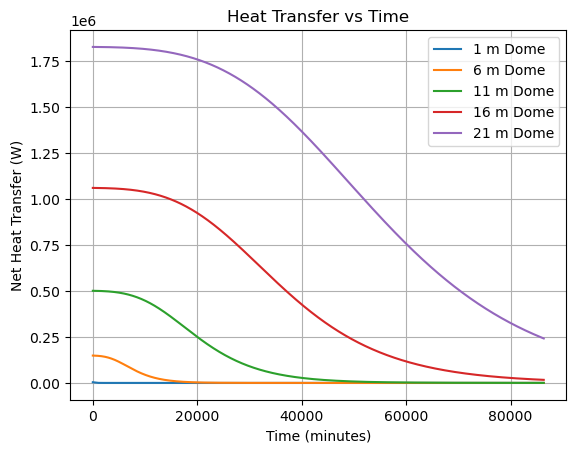

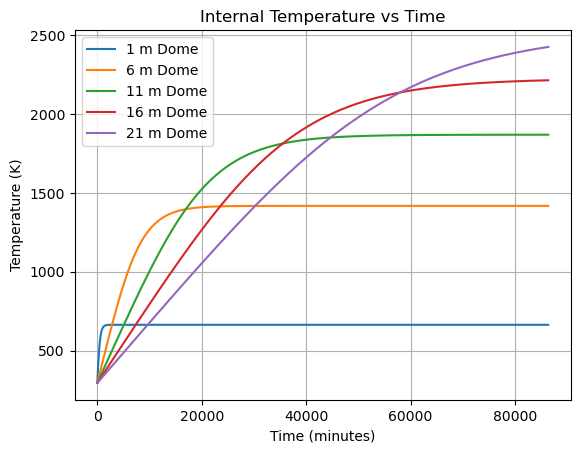

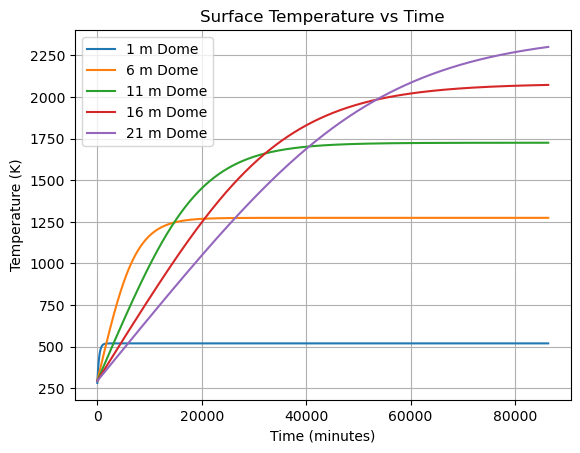

In [ ]:
datasets = []

radii = range(1, 25, 5)
thicknesses = [0.5]
conductivity = 1.15 # W / m^2 / k --- this is taken from a ceramic brick (idk what it would be made of)
dt = 60
duration = 60 * 60 * 24

for radius in radii:
    for thickness in thicknesses:
        wall = Wall(thickness, conductivity)
        sphere = Sphere(radius, EPSILON, wall)
        data = ThermalData(radius, thickness, conductivity)

        for t in range(0, duration, dt):
            data.times.append(t)
            data.internal_temperatures.append(sphere.internal_temperature)
            data.surface_temperatures.append(sphere.surface_temperature)
            data.q_dots.append(sphere.total_heat_transfer())
            sphere.reup_internal_temperature(dt)

        datasets.append(data)

plot.figure()
for data in datasets:
    plot.plot(data.times, data.q_dots, label = f'{data.radius} m Dome')
plot.title("Heat Transfer vs Time")
plot.xlabel("Time (minutes)")
plot.ylabel("Net Heat Transfer (W)")
plot.grid(True)
plot.legend()
plot.show()

plot.figure()
for data in datasets:
    plot.plot(data.times, data.internal_temperatures, label = f'{data.radius} m Dome')
plot.title("Internal Temperature vs Time")
plot.xlabel("Time (minutes)")
plot.ylabel("Temperature (K)")
plot.grid(True)
plot.legend()
plot.show()

plot.figure()
for data in datasets:
    plot.plot(data.times, data.surface_temperatures, label = f'{data.radius} m Dome')
plot.title("Surface Temperature vs Time")
plot.xlabel("Time (minutes)")
plot.ylabel("Temperature (K)")
plot.grid(True)
plot.legend()
plot.show()

### 6 month (lunar months basically) tracking to see more obvious heat is losing during the lunar night

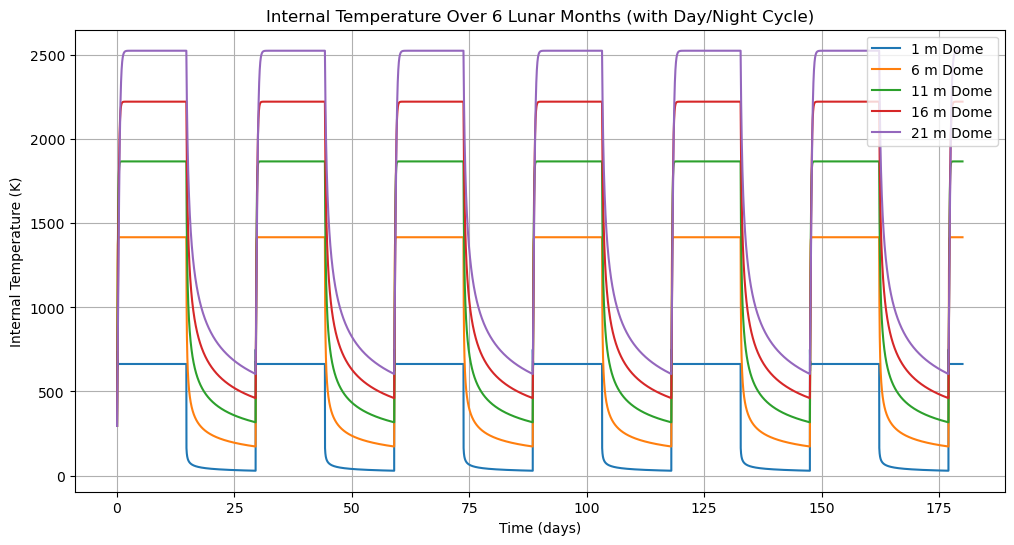

In [ ]:
duration = 60 * 60 * 24 * 180
dt = 60 * 10 # simultion in first order integration for 10 minutes
lunar_day = 60 * 60 * 24 * 29.5
sunlight_hours = 0.5

datasets = []
radii = range(1, 25, 5)
thickness = [0.5, 1.5]
conductivity = 1.15 # again this is like a brick or something

for radius in radii:
    for thickness in thicknesses:
        wall = Wall(thickness, conductivity)
        sphere = Sphere(radius, EPSILON, wall)
        data = ThermalData(radius, thickness, conductivity)

        for t in range(0, duration, dt):
            time_in_cycle = t % lunar_day
            is_day: bool = time_in_cycle < (lunar_day * sunlight_hours)
            solar_input = SOLAR_INTENSITY if is_day else 0 # this basically just turns the sun off if it is night
            sphere.light_intensity = solar_input

            data.times.append(t / (60 * 60 * 24))
            data.internal_temperatures.append(sphere.internal_temperature)
            data.surface_temperatures.append(sphere.surface_temperature)
            data.q_dots.append(sphere.total_heat_transfer())
            sphere.reup_internal_temperature(dt)

        datasets.append(data)

plot.figure(figsize=(12, 6))
for data in datasets:
    plot.plot(data.times, data.internal_temperatures, label=f'{data.radius} m Dome')
plot.title("Internal Temperature Over 6 Lunar Months (with Day/Night Cycle)")
plot.xlabel("Time (days)")
plot.ylabel("Internal Temperature (K)")
plot.grid(True)
plot.legend()
plot.show()